In [82]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

# make samples
n_samples = 1000
X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

print(f"first 5 X feature: \n {X[:5]}")
print(f"\nfirst 5 y feature: \n {y[:5]} ")
print(f"shape of x: {X.shape}, y : {y.shape}")

first 5 X feature: 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

first 5 y feature: 
 [1 1 1 1 0] 
shape of x: (1000, 2), y : (1000,)


In [83]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:, 1],
                        "label": y
                        })
print(circles.head(10))
print(f"\n {circles.label.value_counts()}")

         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0
5 -0.479646  0.676435      1
6 -0.013648  0.803349      1
7  0.771513  0.147760      1
8 -0.169322 -0.793456      1
9 -0.121486  1.021509      0

 label
1    500
0    500
Name: count, dtype: int64


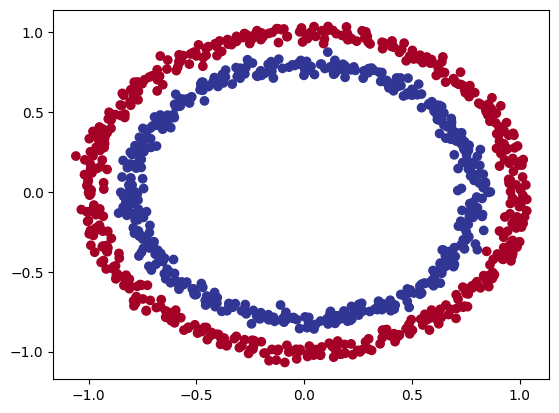

In [84]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0], y=X[:,1],c=y, cmap=plt.cm.RdYlBu)

In [85]:
import torch
X = X #torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 tensor([1., 1., 1., 1., 0.]))

In [133]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
#y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
#y_test = torch.tensor(y_test, dtype=torch.float32)
len(X_train), len(X_test), len(y_train), len(y_test), type(X_train), type(y_train)

(800, 200, 800, 200, torch.Tensor, torch.Tensor)

In [134]:
def get_dev():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"
    
device = get_dev()
device

'cpu'

In [135]:
# create model
class CircleModelV0(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = torch.nn.Linear(in_features=2, out_features=5)
        self.layer_2 = torch.nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x: torch.Tensor):
        return self.layer_2(self.layer_1(1))

model_0  = CircleModelV0().to(device=device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [136]:
model_0 = torch.nn.Sequential(
    torch.nn.Linear(in_features=2, out_features=5),
    torch.nn.Linear(in_features=5, out_features=1)
    ).to(device=device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [137]:
# prefiction without train
untrained_preds = model_0(X_test.to(device))
print(f"length of predictions : {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"length of test samples: {len(y_test)}, shape: {y_test.shape}")
print(f"\n first 10 of predictions: {untrained_preds[:10]}")
print(f"\n first 10 test labels: {y_test[:10]}")

length of predictions : 200, shape: torch.Size([200, 1])
length of test samples: 200, shape: torch.Size([200])

 first 10 of predictions: tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], grad_fn=<SliceBackward0>)

 first 10 test labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [138]:
from torch import nn
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

type(X_test)

torch.Tensor

In [139]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], grad_fn=<SliceBackward0>)

In [140]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], grad_fn=<SigmoidBackward0>)

In [141]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))[:5]

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.], grad_fn=<SqueezeBackward0>)

In [142]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [143]:
# build a train loop

torch.manual_seed(42)
epoches= 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epoches):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()

    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(y_test, test_pred)

        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        if epoch % 10 == 0:
            print(f"Epuch: {epoch}, Loss: {loss:5f}, Accuracy: {acc}, test_loss: {test_loss: 5f}, test_acc : {test_acc: 2f}")





Epuch: 0, Loss: 0.697960, Accuracy: 51.87500000000001, test_loss:  0.598204, test_acc :  57.500000
Epuch: 10, Loss: 0.697677, Accuracy: 52.0, test_loss:  0.598204, test_acc :  58.000000
Epuch: 20, Loss: 0.697415, Accuracy: 52.0, test_loss:  0.603204, test_acc :  57.500000
Epuch: 30, Loss: 0.697174, Accuracy: 52.0, test_loss:  0.613204, test_acc :  56.500000
Epuch: 40, Loss: 0.696952, Accuracy: 51.625, test_loss:  0.613204, test_acc :  56.500000
Epuch: 50, Loss: 0.696746, Accuracy: 51.37500000000001, test_loss:  0.623204, test_acc :  56.000000
Epuch: 60, Loss: 0.696555, Accuracy: 51.37500000000001, test_loss:  0.623204, test_acc :  56.000000
Epuch: 70, Loss: 0.696379, Accuracy: 51.37500000000001, test_loss:  0.623204, test_acc :  56.500000
Epuch: 80, Loss: 0.696215, Accuracy: 51.24999999999999, test_loss:  0.623204, test_acc :  56.500000
Epuch: 90, Loss: 0.696062, Accuracy: 51.37500000000001, test_loss:  0.638204, test_acc :  55.000000
Epuch: 100, Loss: 0.695921, Accuracy: 51.125, test_

In [144]:
import requests
from pathlib import Path

def get_helper():
    if Path("helper_functions.py").is_file():
        print("helper_functions.py already exists")
    else:
        print("Downloding helper_functions.py")
        resp = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        print(resp.status_code)
        with open("helper_functions.py", "wb") as f:
            f.write(resp.content)
    from helper_functions import plot_predictions,plot_decision_boundary

get_helper()

helper_functions.py already exists


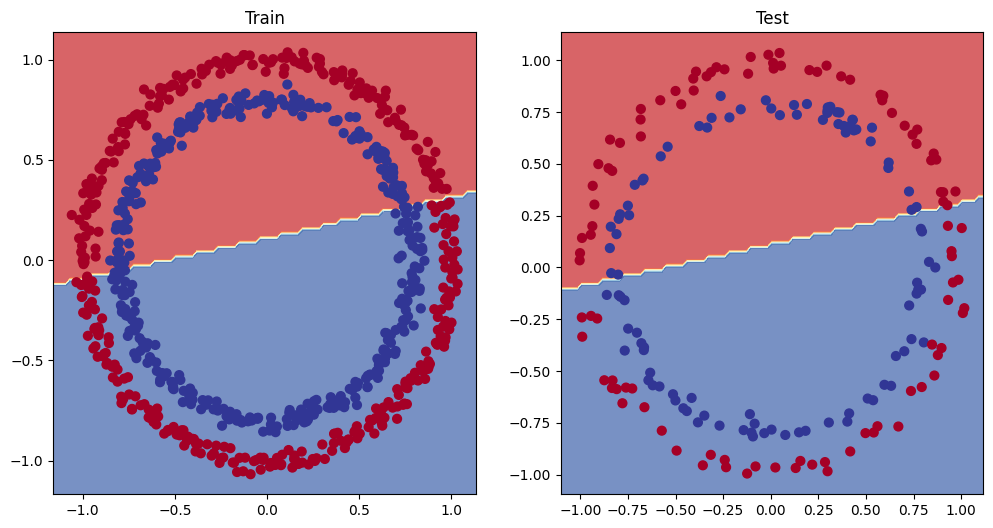

In [145]:
from helper_functions import plot_predictions,plot_decision_boundary
# plot the decision boundaries for training and test
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [146]:
class CircleModelV1(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x: torch.Tensor):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [149]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)

torch.manual_seed(42)

epoches = 1000

X_train, y_train = X_train.to(device),y_train.to(device)
X_test, y_test = (X_test).to(device),(y_test).to(device)

for epoch in range(epoches):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    model_1.eval()

    with torch.inference_mode():
        test_logit = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logit))

        test_loss = loss_fn(test_logit, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, Loss :{loss: 5f}, Accuracy: {acc:2f}, test_loss : {test_loss: 5f}, test_acc: {test_acc: 2f}")

Epoch: 0, Loss : 0.693948, Accuracy: 50.750000, test_loss :  0.692611, test_acc:  51.000000
Epoch: 10, Loss : 0.693916, Accuracy: 50.625000, test_loss :  0.692616, test_acc:  51.000000
Epoch: 20, Loss : 0.693885, Accuracy: 50.625000, test_loss :  0.692622, test_acc:  50.500000
Epoch: 30, Loss : 0.693856, Accuracy: 50.625000, test_loss :  0.692629, test_acc:  50.500000
Epoch: 40, Loss : 0.693828, Accuracy: 50.750000, test_loss :  0.692637, test_acc:  50.500000
Epoch: 50, Loss : 0.693802, Accuracy: 50.750000, test_loss :  0.692645, test_acc:  50.500000
Epoch: 60, Loss : 0.693777, Accuracy: 50.500000, test_loss :  0.692654, test_acc:  51.000000
Epoch: 70, Loss : 0.693752, Accuracy: 50.125000, test_loss :  0.692664, test_acc:  51.000000
Epoch: 80, Loss : 0.693729, Accuracy: 50.000000, test_loss :  0.692674, test_acc:  50.500000
Epoch: 90, Loss : 0.693707, Accuracy: 50.000000, test_loss :  0.692685, test_acc:  50.500000
Epoch: 100, Loss : 0.693686, Accuracy: 50.250000, test_loss :  0.692696

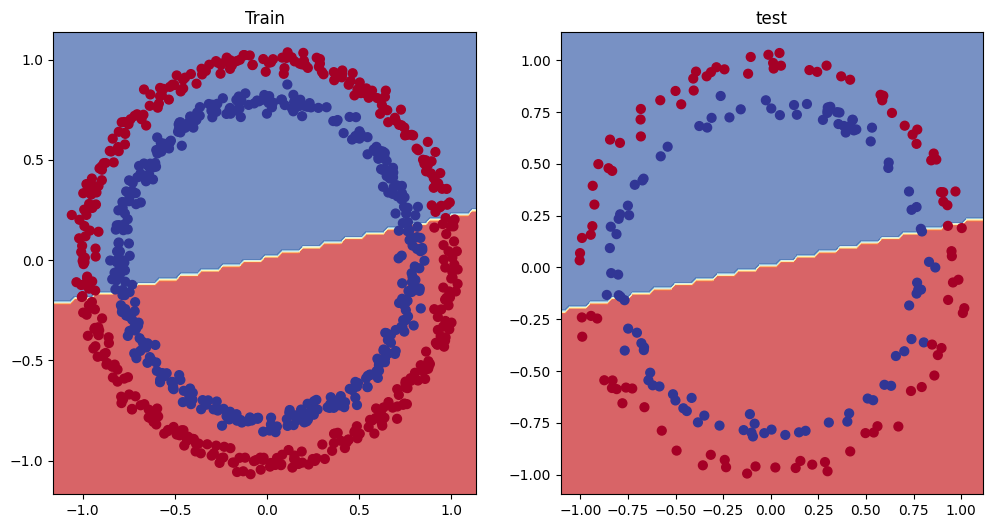

In [150]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_1, X_test, y_test)

In [151]:
# straight line 
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [152]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split],y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

print(len(X_train_regression),
      len(y_train_regression),
      len(X_test_regression),
      len(y_test_regression)
      )

80 80 20 20


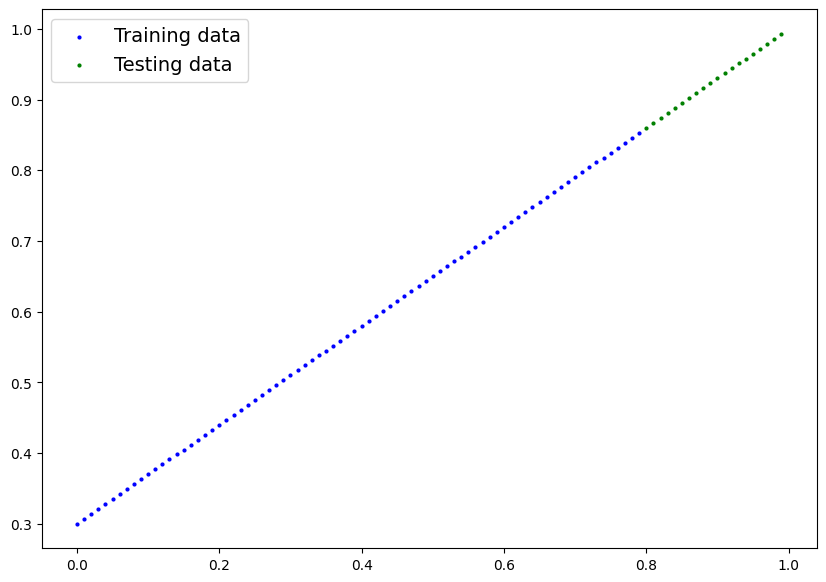

In [153]:
plot_predictions(train_data=X_train_regression,train_labels=y_train_regression,test_data=X_test_regression,test_labels=y_test_regression)

In [156]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device=device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [158]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

torch.manual_seed(42)
epoches = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epoches):
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    model_2.eval()

    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

        if epoch % 10 == 0:
            print(f"epoch: {epoch}, loss: {loss:5f}, test loss: {test_loss:5f}")

epoch: 0, loss: 0.064547, test loss: 0.024250
epoch: 10, loss: 0.055821, test loss: 0.007598
epoch: 20, loss: 0.052910, test loss: 0.006993
epoch: 30, loss: 0.055569, test loss: 0.011717
epoch: 40, loss: 0.061987, test loss: 0.011316
epoch: 50, loss: 0.068332, test loss: 0.012728
epoch: 60, loss: 0.044283, test loss: 0.021898
epoch: 70, loss: 0.050284, test loss: 0.010127
epoch: 80, loss: 0.050083, test loss: 0.005718
epoch: 90, loss: 0.059057, test loss: 0.011484
epoch: 100, loss: 0.052957, test loss: 0.007735
epoch: 110, loss: 0.052748, test loss: 0.007127
epoch: 120, loss: 0.044195, test loss: 0.015747
epoch: 130, loss: 0.044505, test loss: 0.030676
epoch: 140, loss: 0.067515, test loss: 0.026324
epoch: 150, loss: 0.068151, test loss: 0.011997
epoch: 160, loss: 0.068861, test loss: 0.005088
epoch: 170, loss: 0.044866, test loss: 0.018336
epoch: 180, loss: 0.044364, test loss: 0.018817
epoch: 190, loss: 0.059062, test loss: 0.006097
epoch: 200, loss: 0.052969, test loss: 0.006133
epo

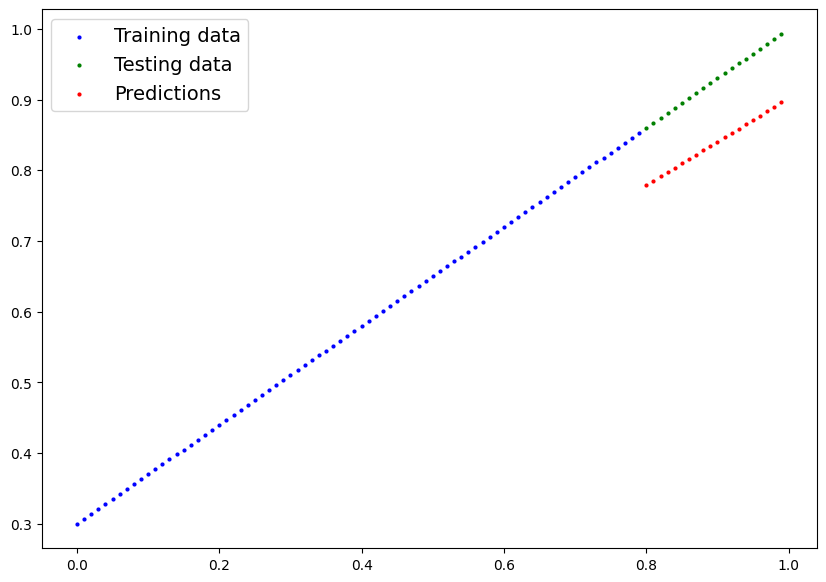

In [160]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)

    plot_predictions(train_data=X_train_regression, train_labels=y_train_regression,test_data=X_test_regression,test_labels=y_test_regression.cpu(), predictions=y_preds.cpu())

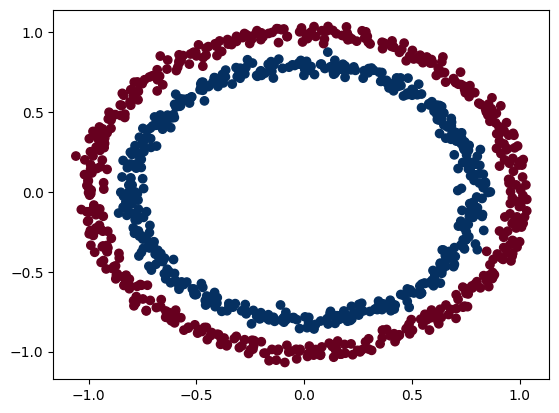

In [162]:
# make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples=n_samples,noise=0.03, random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdBu)



In [166]:
import torch
from sklearn.model_selection import train_test_split

#X = torch.from_numpy(X).type(torch.float)
#y = torch.from_numpy(y).type(torch.float)

X_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
X_train[:5], y_train[:5], type(X_train),type(y_train)

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]),
 torch.Tensor,
 torch.Tensor)

In [167]:
class CircleModelV3(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV3().to(device=device)
model_3

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

torch.manual_seed(42)
epoches = 2000

for epoch in range(epoches):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_3.eval()

    with torch.inference_mode():
        test_logits = model_3(X_test)
        test_pred = torch.round(torch.sigmoid(test_logit))

        test_loss = loss_fn(test_logit, y_test)
        test_acc=  accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"epoch: {epoch}, loss: {loss:5f}, accuracy: {acc:2f}, test_loss:{test_loss:5f}, test_acc: {test_acc: 2f}")

epoch: 0, loss: 0.568184, accuracy: 87.750000, test_loss:0.693779, test_acc:  49.000000
epoch: 100, loss: 0.481530, accuracy: 93.500000, test_loss:0.693779, test_acc:  49.000000
epoch: 200, loss: 0.370562, accuracy: 97.750000, test_loss:0.693779, test_acc:  49.000000
epoch: 300, loss: 0.254576, accuracy: 99.000000, test_loss:0.693779, test_acc:  49.000000
epoch: 400, loss: 0.171798, accuracy: 99.500000, test_loss:0.693779, test_acc:  49.000000
epoch: 500, loss: 0.121877, accuracy: 99.625000, test_loss:0.693779, test_acc:  49.000000
epoch: 600, loss: 0.091229, accuracy: 99.875000, test_loss:0.693779, test_acc:  49.000000
epoch: 700, loss: 0.071004, accuracy: 99.875000, test_loss:0.693779, test_acc:  49.000000
epoch: 800, loss: 0.057734, accuracy: 99.875000, test_loss:0.693779, test_acc:  49.000000
epoch: 900, loss: 0.048526, accuracy: 99.875000, test_loss:0.693779, test_acc:  49.000000
epoch: 1000, loss: 0.041760, accuracy: 99.875000, test_loss:0.693779, test_acc:  49.000000
epoch: 1100

In [172]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

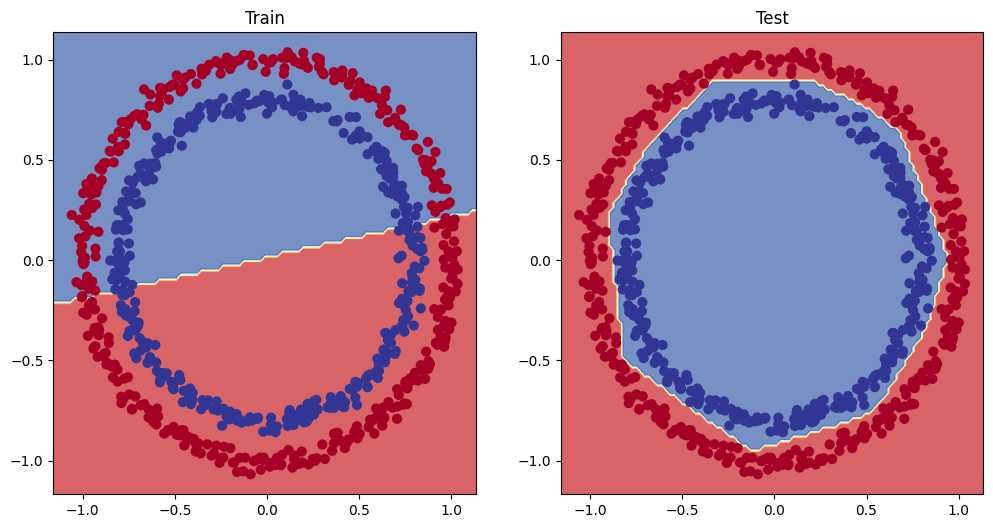

In [174]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_train, y_train)

[[-8.41339595  6.93516545]
 [-5.76648413 -6.43117072]
 [-6.04213682 -6.76610151]
 [ 3.95083749  0.69840313]
 [ 4.25049181 -0.28154475]] [3 2 2 1 1]


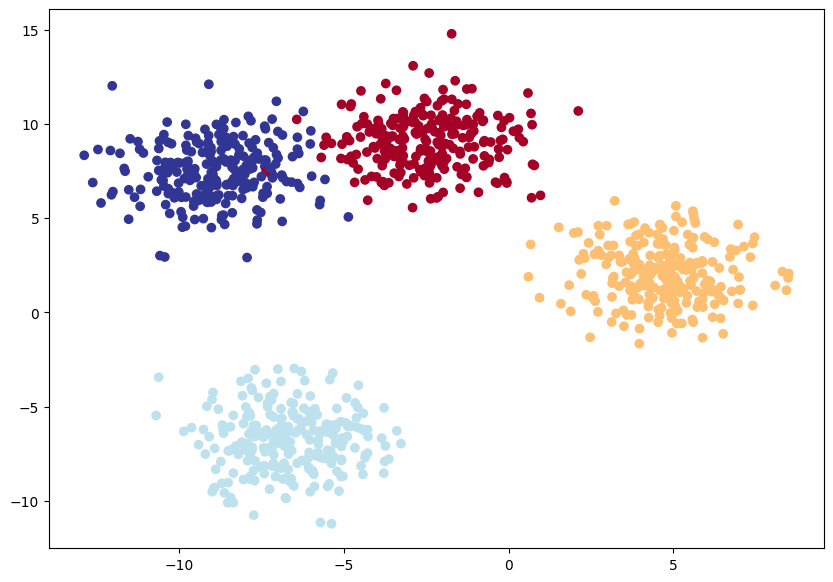

In [196]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASS = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, 
                            n_features=NUM_FEATURES, # X features``
                            centers=NUM_CLASS,  #y labels
                            cluster_std=1.5,    # give the cluster a little shake up
                            random_state=RANDOM_SEED
                            )
                        
X_blob_train,X_blob_test, y_blob_train,y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2,random_state=RANDOM_SEED)
X_blob_train = torch.from_numpy(X_blob_train).type(torch.float)
X_blob_test = torch.from_numpy(X_blob_test).type(torch.float)
y_blob_train = torch.from_numpy(y_blob_train).type(torch.long)
y_blob_test =  torch.from_numpy(y_blob_test).type(torch.long)
type(X_blob_train), type(X_blob_test)
print(X_blob[:5], y_blob[:5])

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)


In [197]:
device = get_dev()

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_unit=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_unit),
            #nn.Relu(),
            nn.Linear(in_features=hidden_unit, out_features=hidden_unit),
            #nn.Relu(),
            nn.Linear(in_features=hidden_unit, out_features=output_features)
        )

    def forward(self, x: torch.Tensor):
        return self.linear_layer_stack(x)
    

model_4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASS, hidden_unit=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [198]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

print(model_4(X_blob_train.to(device))[:5])
print(model_4(X_blob_train.to(device))[0].shape, NUM_CLASS)

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)
torch.Size([4]) 4


In [200]:
torch.manual_seed(42)
epoches = 1000

for epoch in range(epoches):
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)

    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    model_4.eval()

    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred = test_pred)
        
        if epoch % 10 == 0:
            print(f"epoch: {epoch}, loss: {loss: 5f}, accuracy: {acc: 2f}, test_loss: {test_loss:5f}, test_acc: {test_acc:2f}")


epoch: 0, loss:  0.023022, accuracy:  99.375000, test_loss: 0.011335, test_acc: 99.500000
epoch: 10, loss:  0.023000, accuracy:  99.375000, test_loss: 0.011310, test_acc: 99.500000
epoch: 20, loss:  0.022978, accuracy:  99.375000, test_loss: 0.011286, test_acc: 99.500000
epoch: 30, loss:  0.022957, accuracy:  99.375000, test_loss: 0.011261, test_acc: 99.500000
epoch: 40, loss:  0.022936, accuracy:  99.375000, test_loss: 0.011237, test_acc: 99.500000
epoch: 50, loss:  0.022914, accuracy:  99.375000, test_loss: 0.011213, test_acc: 99.500000
epoch: 60, loss:  0.022893, accuracy:  99.375000, test_loss: 0.011189, test_acc: 99.500000
epoch: 70, loss:  0.022872, accuracy:  99.375000, test_loss: 0.011166, test_acc: 99.500000
epoch: 80, loss:  0.022851, accuracy:  99.375000, test_loss: 0.011143, test_acc: 99.500000
epoch: 90, loss:  0.022831, accuracy:  99.375000, test_loss: 0.011120, test_acc: 99.500000
epoch: 100, loss:  0.022810, accuracy:  99.375000, test_loss: 0.011097, test_acc: 99.500000

In [202]:
model_4.eval()

with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

print(f"Predictions: {y_preds[:10]}\n labels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
 labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5


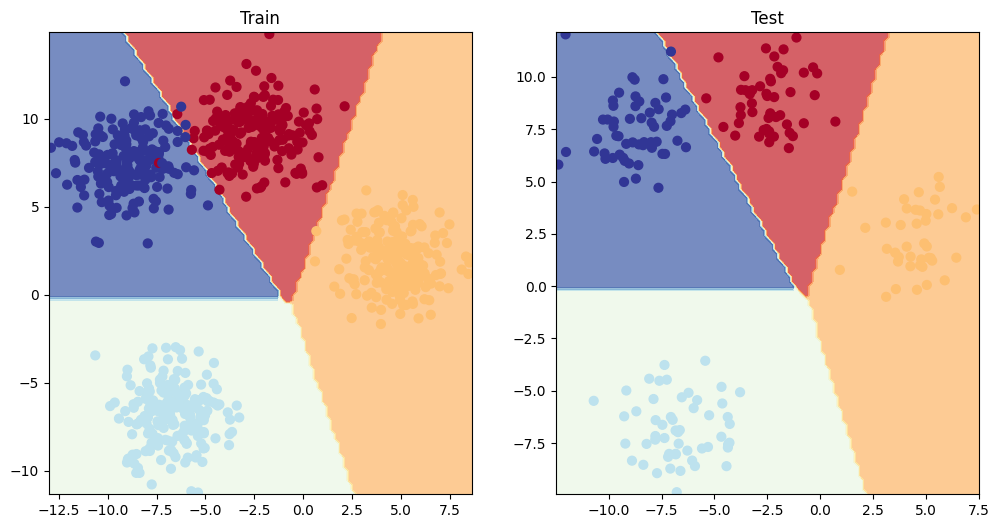

In [206]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)